#  Прогнозирование заказов такси

## Описание задачи

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Необходимо построить модель для этого предсказания и, используя метрику MSE, добиться точности не более 0.48.

План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка данных

Импортируем все необходимые библиотеки:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

Загрузим данные, определив первый столбец как дату и сделав его индексом.

In [2]:
data = pd.read_csv('C:/Users/79283/Desktop/project/taxi/taxi.csv', parse_dates=[0], index_col=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Этот временной ряд показывает количество заказов на такси за каждые 10 минут. Посмотрим на общую информацию о таблице:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные за каждые 10 минут идут от *01.03.2018* до *31.08.2018*

Перед тем как анализировать временной ряд, необходимо убедиться что ряд монотонный - то есть дни идут последовательно. Проверим это специальным атрибутом:

In [4]:
data.index.is_monotonic

True

Столбец индексов монотонный, по условию осталось лишь заресемплить ряд до одного часа:

In [5]:
data = data.resample('1H').sum()

Ряд монотонный, сгруппирован по часу. Данные подготовлены, можно переходить к анализу.

## Анализ

Нельзя предсказывать нестационарный временной ряд. Стационарность включает в себя постоянство математического ожидания, дисперсии и ковариации значений в зависимости от времени. Тест Дики-Фулера поможет определить стационарность.

Если *p-значение* ***меньше*** *уровня значимости в 0.5*, то можно считать ряд стационарным.

In [6]:
sm.tsa.adfuller(data)[1]

0.028940051402615248

Временной ряд стационарен. Нарисуем скользящее среднее с окном в один день (24 часа) и стандартное отклонение, чтобы визуально оценить ряд.

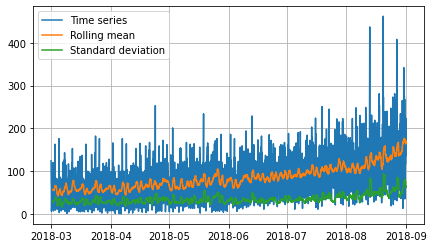

In [7]:
plt.figure(figsize=(7, 4))
plt.grid()

plt.plot(data, label='Time series')
plt.plot(data.rolling(24).mean(), label='Rolling mean')
plt.plot(data.rolling(24).std(), label='Standard deviation')
plt.legend()

* ряд линейный, дополнительных преобразований не требуется
* заметен небольшой положительный тренд
* возможно присутствует сезонность

Посмотрим на поведение клиентов, проанализируя тренд и сезонность. Используем seasonal_decompose библиотеки statsmodels чтобы получить данные:

In [8]:
decomposer = seasonal_decompose(data)

trend = decomposer.trend
seasonal = decomposer.seasonal

Тренд - это общая компонента временного ряда, которая может меняться со временем. По сути, это более сглаженный временной ряд, выведем его:

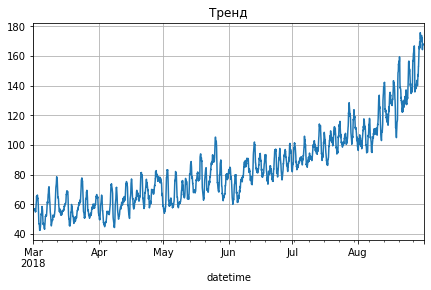

In [9]:
plt.figure(figsize=(7, 4))
trend.plot(title='Тренд')
plt.grid()

Количество заказов такси растет. Тренд - линейный и положительный, однако недостаточно, чтобы тест Дики-Фуллера показал нестационарность.

Сезонность - это периодически меняющаяся компонента. Попробуем отыскать сезонность в течение одного дня:

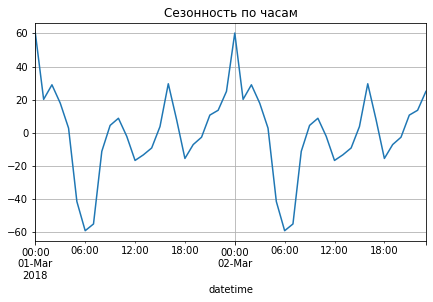

In [10]:
plt.figure(figsize=(7, 4))
seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca(), title='Сезонность по часам')
plt.grid()

#seasonal.plot(ax=plt.gca(), title='Сезонность по месяцам') 
#plt.grid()
#график показывает что месячной сезонности нет, лишь часовая.

Чаще всего такси заказывают в полночь, меньше всего ранним утром в 6 часов.

Следующим шагом определим сезонность, зависящую от дня недели:

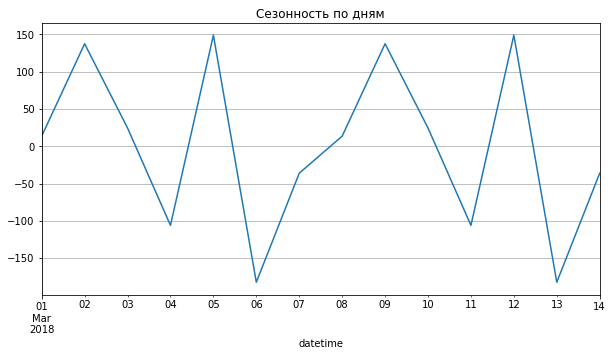

In [11]:
seasonal = seasonal_decompose(data.resample('1D').sum()).seasonal

plt.figure(figsize=(10, 5))
seasonal['2018-03-01': '2018-03-14'].plot(title='Сезонность по дням')
plt.grid()

Дате *01.03.2018* соотвествует четверг, следовательно: 

* в понедельник и пятницу **больше** всего заказов
* в воскресенье и вторник заказов **меньше** всего

**Выводы**
1. Тест Дики-Фуллера показал, что временной ряд стационарен - значит подходит для прогноза.
2. Люди все чаще пользуются такси - тренд положительный и линейный.
3. В полночь заказов больше всего, в 6:00 - меньше всего.
4. Люди чаще пользуются такси по пятницам и понедельникам, реже всего - по воскресеньям и вторникам.

## Обучение

Пришло время обучения, мы будем использовать структурные модели. Это означает, что мы займемся созданием признаков для обучения таких моделей, как:
* LinearRegression
* RandomForest
* CatBoost
* LightGBM

### Создание признаков

Перед обучением мы создадим признаки, по которым модели будут обучаться, а именно:
* Календарные признаки.
* Отстающие значения. Они могут показать будет ли функция уменьшаться или увеличиваться
* Значения скользящей средней. Задает общий  тренд временного ряда.

На этапе анализа мы выяснили, что ряд имеет сезонность и количество заказов зависит от **часа** и **дня недели** - это будут наши календарные признаки.

Скользящая средняя в моменте *X* не будет учитывать этот самый *X*, чтобы не было утечки целевого признака. 

Функция ниже будет создавать сразу все признаки:

In [12]:
def set_features(df, max_lag=0, rolling_mean_size=0):
    data = df.copy()
    
    #календарные признаки
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    #отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    #скользящее среднее
    data['rolling'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    #после создания столбца с отстающими значениями, появляются пропуски в первых строках
    data.dropna(inplace=True)
    
    return data

Ниже написана функция, которая делит датафрейм на выборки, которые возвращает. Разбивает на тренировочную, валидационную и тестовую выбрки в пропорции 8:1:1. Данные не будут перемешаны.

In [13]:
def split_df(df):
    train, test = train_test_split(df, shuffle=False, test_size=0.1)
    train, valid = train_test_split(train, shuffle=False, test_size=1/9)
    train = train.dropna()
    
    train_x = train.drop('num_orders', axis=1)
    train_y = train['num_orders']

    valid_x = valid.drop('num_orders', axis=1)
    valid_y = valid['num_orders']

    test_x = test.drop('num_orders', axis=1)
    test_y = test['num_orders']

    return train_x, train_y, valid_x, valid_y, test_x, test_y

Переходим к обучению моделей.

### Обучение моделей

Процесс обучения будет проходить следующим образом:
1. Модель загружается в функцию по подбору лучшего набора признаков
2. Каждый цикл будет вбивать в функцию `set_features()` разные значения
3. Датафрейм, который вернет эта функция, попадет в функцию разделения на выборки - `split_df()`.
3. Каждый набор признаков тестируется на валидационной выборке и тем самым будет выбран наилучший набор для каждой модели

Вдобавок к этому будет выводиться график наложения прогноза на ответы, а также сравнения полученной сезонности с истинной. 
 Функция выведет значения RMSE на валидационной, а также RMSE которая будет посчитана на тренировочной выборке. Сравнение этих двух величин поможет оценить степень переобучения.
 Соответственно будут выведены лучшие параметры для построения признаков.
 
Все это будет реализовывать функция `get_best_model()`, которой понадобится лишь модель.

In [14]:
def get_best_model(model):
    #параметры признаков и точность
    best_score = 50
    best_train_score = None
    best_max_lags = None
    best_rolling_mean_size = None
    
    #переменные по которым будут строиться графики
    final_predictions = None
    target = None
    
    #цикл в котором происходит подбор лучших признаков, лучшие признаки и прогнозы будут сохраняться в переменные выше
    for lag in range(1, 81, 5):
        for size in range(3, 22, 3):
    #создание признаков -> деление на выборки -> обучение-прогноз
            result = split_df(set_features(data, lag, size))
            model.fit(result[0],result[1])
            preds = model.predict(result[2])
            rmse = mean_squared_error(preds, result[3]) ** 0.5
    #сохранение наилучших результатов
            if rmse < best_score: 
                best_score = rmse
                best_max_lags = lag
                best_rolling_mean_size = size
                
                #обучения и предикт тренировочной выборки
                preds_train = model.predict(result[0])
                rmse_train = mean_squared_error(preds_train, result[1]) ** 0.5
                best_train_score = rmse_train
                
                #запись лучших прогнозов в переменные
                final_predictions = pd.Series(preds)
                final_predictions.index = result[3].index
                target = result[3]
                
    plt.figure(figsize=(15,7))
    plt.grid()
    plt.title('Наложение прогноза на ответы')
    plt.plot(target, color='grey', linewidth=3, linestyle='--', alpha=0.5, label='Actual')
    plt.plot(final_predictions, color='red', label='Model')
    plt.xticks(rotation=30)
    plt.legend()
    plt.show()
    
    plt.title('Сравнение сезонности по часам')
    (seasonal_decompose(target).seasonal['2018-07-27':'2018-07-29']
             .plot(ax=plt.gca(), color='grey', linewidth=3, linestyle='--', alpha=.5, label='Actual'))
    
    (seasonal_decompose(final_predictions).seasonal['2018-07-27':'2018-07-29']
             .plot(ax=plt.gca(), color='red', label='Model'))


    print('RMSE =', best_score)
    print('RMSE на тренировочной выборке =', best_train_score)
    print('max_lags =', best_max_lags)
    print('rolling_mean_size =', best_rolling_mean_size)

Функция готова, теперь по очереди применяем ее к каждой модели.

**LinearRegression**

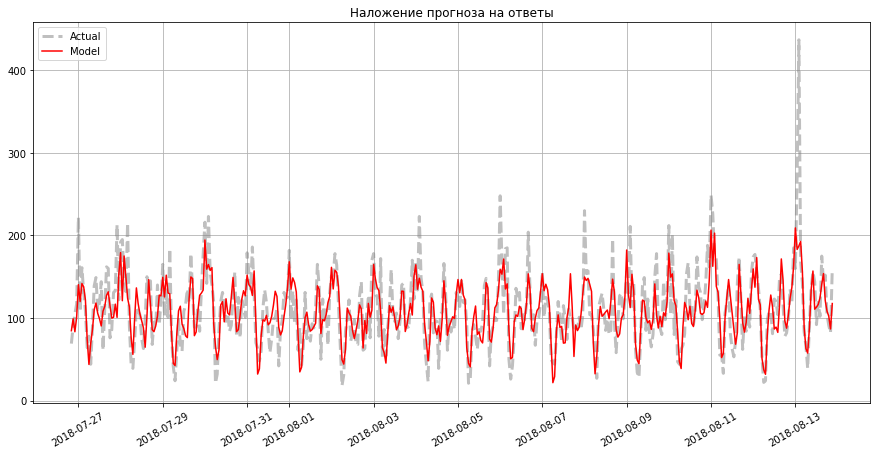

RMSE = 30.791835645325122
RMSE на тренировочной выборке = 21.491317394224897
max_lags = 76
rolling_mean_size = 21
Wall time: 3.7 s


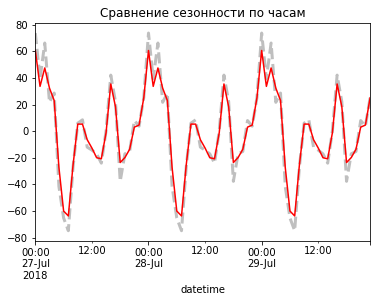

In [15]:
%%time
get_best_model(LinearRegression())

**RandomForest**

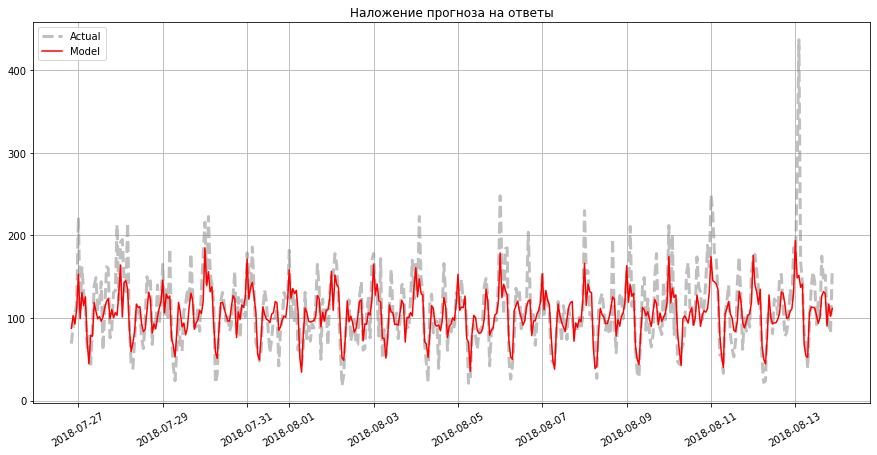

RMSE = 31.17336479401358
RMSE на тренировочной выборке = 7.826819323329629
max_lags = 76
rolling_mean_size = 6
Wall time: 9min 24s


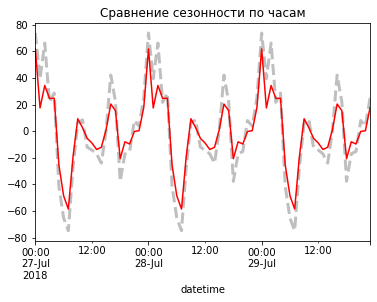

In [16]:
%%time
get_best_model(RandomForestRegressor())

**CatBoost**


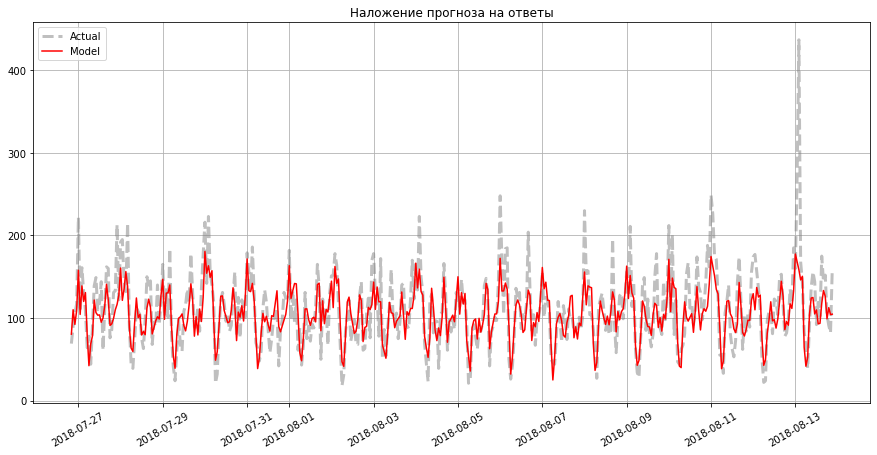

RMSE = 29.864263001758612
RMSE на тренировочной выборке = 8.710026556550677
max_lags = 76
rolling_mean_size = 15
Wall time: 5min 45s


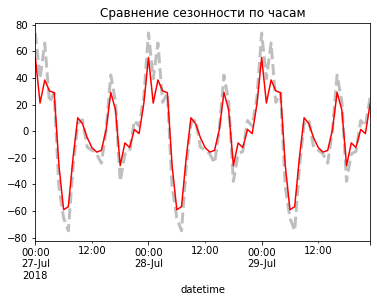

In [17]:
%%time
get_best_model(CatBoostRegressor(loss_function='RMSE', verbose=0))

#### LightGBM

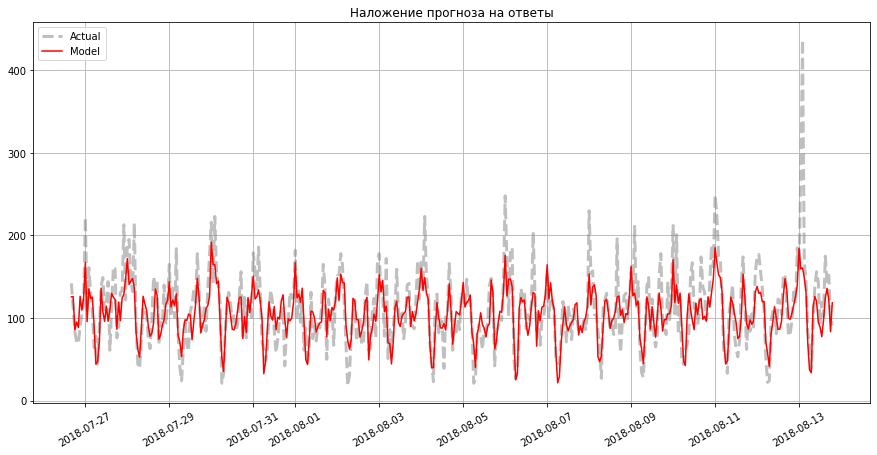

RMSE = 29.612407737262572
RMSE на тренировочной выборке = 9.454987225884356
max_lags = 61
rolling_mean_size = 9
Wall time: 15.2 s


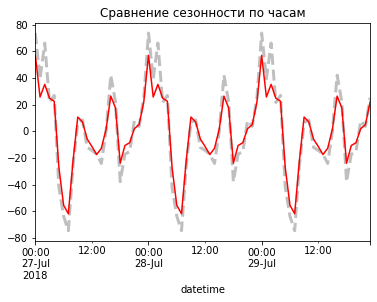

In [18]:
%%time
get_best_model(LGBMRegressor(objective='regression', force_col_wise=True))

#### Выводы

Весь процесс этого этапа был основан на подборе признаков для обучения, каждая модель хорошо определила сезонность и достигла хорошего качества, в таблице можно представить весь результат:

|    |RMSE| RMSE (train)| Wall time |
|:---|:---|:------------|:----------|
|**LinearRegression**|30.792|21.491|3.84s|
|**RandomForest**|31.206|8.202|9m 29s|
|**CatBoost**|29.864|8.710|5min 45s|
|**LightGBM**|29.612|9.455|13.4s|

По таблице можно сделать следующие выводы:
1. Наименее переобученной является линейная регрессия, она имеет неплохую точность, однако ее преимущество в том, что она работает быстрее.
2. Случайный лес наименее точный, наиболее переобученный и наиболее долгий.
3. CatBoost и LightGBM дают лучшую точность однако они переобучены, еще нужно отметить что первый существенно дольше обучается.

Линейная регрессия хоть и имеет немного меньшую точность, однако степень переобучения у нее гораздо ниже, потому безопаснее использовать именно ее.

## Тестирование

Мы выбрали линейную регрессию в качестве лучшей модели. Перед тестом нужно выделить отдельно тестовую выборку, заодно создадим наилучший набор признаков, который мы определили на этапе обучения:

In [19]:
train_x, train_y = split_df(set_features(data, 76, 21))[0:2]
test_x, test_y = split_df(set_features(data, 76, 21))[4:6]

Переходим к тестированию:

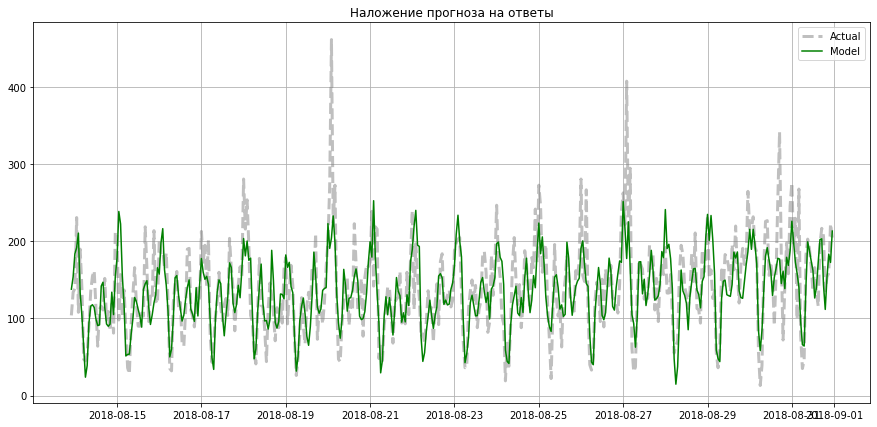

RMSE = 41.500098187943905


In [20]:
model = LinearRegression()
model.fit(train_x, train_y)
preds = pd.Series(model.predict(test_x))
preds.index = test_y.index

plt.figure(figsize=(15,7))
plt.grid()
plt.title('Наложение прогноза на ответы')
plt.plot(test_y, color='grey', linewidth=3, linestyle='--', alpha=0.5, label='Actual')
plt.plot(preds, color='green', label='Model')
plt.legend()
plt.show()

rmse = mean_squared_error(preds, test_y) ** 0.5
print('RMSE =', rmse)

## Итоговый вывод

Был проведен анализ временного ряда с целью выявить некоторые закономерности, а также подготовить ряд к обучению. Как известно нестационарный ряд нельзя прогнозировать, поэтому мы использовали тест Дики-Фулера для проверки на стационарность. Тренд линейный и положительный, однако математическое ожидание меняется не так сильно, чтобы это было критично для стационарности. 

Так как изначально мы собирались использовать структурные модели - необходимо как можно больше узнать о закономерностях, так мы выявили сезонность. 
1. Количество заказов такси зависит от часа. В полночь и около 17 часов количество заказов наибольшее, в 6 утра заказов сильно меньше чем в другое время.
2. Так же количество зависит и от дня недели. По пятницам и понедельникам люди заказывают такси чаще чем в другие дни, по воскресеньям и вторникам - существенно меньше.

Эта информация была важна для подбора признаков. Признаки для обучения были следующие:
1. Календарные. Сезонность как раз таки дала понять, что **нам важен час и день недели**.
2. Отстающие значения. Они дают информацию о предыдущих днях, у лучшей модели в признаках каждый объект **содержал информацию аж до 76 предыдущих днях**.
3. Скользящая средняя. Дает модели информацию об общем тренде. У лучшей модели **окно скользящей средней было равно в 21** (час).

Среди четырех моделей была выбрана линейная регрессия как наименее переобученная, быстрая и точная. Всех остальных моделей связывало то, что степень переобучения была существенно выше, хоть точность у некоторых на валидационной выборке была немного лучше.

Было проведено тестирование:
***RMSE = 41.5*** \
Модель успешно справляется с прогнозированием заказов такси на следующий час.